<a href="https://colab.research.google.com/github/berdaniera/experiments/blob/master/Airports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Routing problem example

**Scenario:** 5 trips with three airplanes. (Extensions include capacity and time window constraints.)

In [ ]:
!pip install ortools
!pip install geopandas

## Load packages and data

Select random airport locations in the US as our points and generate random trips.

In [29]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from sklearn.neighbors import DistanceMetric
from math import radians
import pandas as pd
import numpy as np
from random import sample

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
airports = pd.read_csv("https://ourairports.com/countries/US/airports.csv")

In [64]:
random_air = airports[(airports.type == "small_airport") & (airports.region_name != 'Alaska')].sample(11)
random_air['nid'] = range(11)
random_air

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,country_name,iso_country,region_name,iso_region,local_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,score,last_updated,nid
4993,18456,K1C2,small_airport,Howell New Lenox Airport,41.479801,-87.921303,753.0,NaN,United States,US,Illinois,US-IL,IL,NaN,0,NaN,NaN,1C2,NaN,NaN,NaN,50,2009-05-24T21:30:16+00:00,0
1743,13155,69N,small_airport,Slatington Airport,40.763599,-75.604897,380.0,NaN,United States,US,Pennsylvania,US-PA,PA,Slatington,0,69N,NaN,69N,NaN,NaN,NaN,50,2008-06-13T14:30:04+00:00,1
3146,12117,57AZ,small_airport,La Cholla Airpark,32.446633,-111.002898,2940.0,NaN,United States,US,Arizona,US-AZ,AZ,Oro Valley,0,57AZ,NaN,57AZ,NaN,https://en.wikipedia.org/wiki/La_Cholla_Airpark,"tucson, la cholla",50,2021-04-20T17:37:23+00:00,2
822,20292,KL26,small_airport,Hesperia Airport,34.377201,-117.316002,3390.0,NaN,United States,US,California,US-CA,CA,Hesperia,0,KL26,NaN,L26,NaN,NaN,NaN,50,2008-06-13T14:30:04+00:00,3
12164,10626,3MO4,small_airport,Penman Airport,36.450600,-89.628098,287.0,NaN,United States,US,Missouri,US-MO,MO,Portageville,0,3MO4,NaN,3MO4,NaN,NaN,NaN,50,2008-06-13T14:30:04+00:00,4
14474,14375,7Q7,small_airport,White River Municipal Airport,43.561699,-100.741997,2151.0,NaN,United States,US,South Dakota,US-SD,SD,White River,0,7Q7,NaN,7Q7,NaN,NaN,NaN,50,2008-06-13T14:30:04+00:00,5
501,21057,KSFM,small_airport,Sanford Seacoast Regional Airport,43.393902,-70.708000,244.0,NaN,United States,US,Maine,US-ME,ME,Sanford,0,KSFM,SFM,SFM,http://www.sanfordmaine.org/index.asp?Type=B_B...,https://en.wikipedia.org/wiki/Sanford_Regional...,Sanford NAAF,50,2015-05-23T13:17:03+00:00,6
6105,7652,10AZ,small_airport,Pierce Airport,33.366402,-112.617996,860.0,NaN,United States,US,Arizona,US-AZ,AZ,Buckeye,0,10AZ,NaN,10AZ,NaN,NaN,NaN,50,2008-06-13T14:30:04+00:00,7
826,20282,KL05,small_airport,Kern Valley Airport,35.728298,-118.419998,2614.0,NaN,United States,US,California,US-CA,CA,Kernville,0,KL05,NaN,L05,NaN,https://en.wikipedia.org/wiki/Kern_Valley_Airport,NaN,50,2008-06-13T14:30:04+00:00,8
11628,6587,01FA,small_airport,Rybolt Ranch Airport,28.589399,-81.144203,55.0,NaN,United States,US,Florida,US-FL,FL,Orlando,0,01FA,NaN,01FA,NaN,NaN,NaN,50,2008-06-13T14:30:04+00:00,9


### Plot map

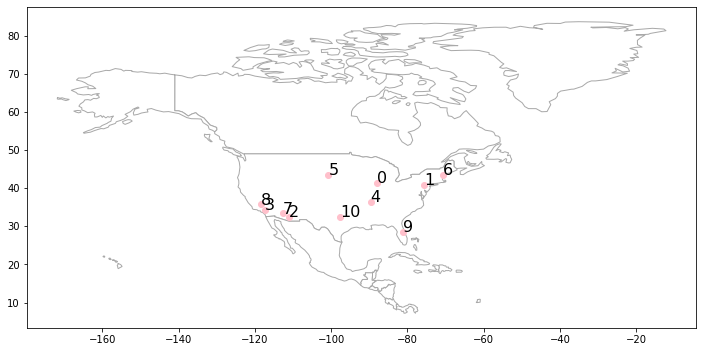

In [65]:
gdf = gpd.GeoDataFrame(random_air, 
                       geometry=gpd.points_from_xy(random_air.longitude_deg, random_air.latitude_deg))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot(color='white', edgecolor='darkgrey')
for x, y, label in zip(random_air.longitude_deg, random_air.latitude_deg, random_air.nid):
    ax.annotate(label, xy=(x, y), xytext=(0, 0), fontsize=16, textcoords="offset points")
gdf.plot(ax=ax, color='pink')

### Generate data for analysis

In [78]:
# Make trips
our_trips = [
        [1, 6],
        [2, 10],
        [4, 3],
        [5, 9],
        [7, 8],
    ]
print("Sampled trip origins and destinations:")
print(our_trips)

# get Haversine distance between each point in km
random_air['latitude_rad'] = np.radians(random_air['latitude_deg'])
random_air['longitude_rad'] = np.radians(random_air['longitude_deg'])
dist = DistanceMetric.get_metric('haversine')
air_coords = random_air[['latitude_rad','longitude_rad']].to_numpy()
distance_km = dist.pairwise(air_coords)*6373 # km distance

data = {}
data['distance_matrix'] = np.ndarray.tolist(distance_km.astype(np.int))
data['num_vehicles'] = 3
data['depot'] = 0 # this is the starting/ending depot
data['pickups_deliveries'] = our_trips

# maximum travel distance
maxdist = int(max(5000, np.amax(distance_km)*4))

print("Distance between each point:")
print(distance_km.astype(np.int))

Sampled trip origins and destinations:
[[1, 6], [2, 10], [4, 3], [5, 9], [7, 8]]
Distance between each point:
[[   0 1034 2274 2682  578 1075 1426 2350 2711 1559 1333]
 [1034    0 3268 3709 1308 2087  498 3359 3744 1444 2174]
 [2274 3268    0  624 2006 1526 3698  182  774 2883 1250]
 [2682 3709  624    0 2511 1754 4101  448  180 3472 1835]
 [ 578 1308 2006 2511    0 1231 1783 2119 2579 1181  867]
 [1075 2087 1526 1754 1231    0 2410 1531 1741 2412 1275]
 [1426  498 3698 4101 1783 2410    0 3776 4121 1892 2650]
 [2350 3359  182  448 2119 1531 3776    0  592 3036 1399]
 [2711 3744  774  180 2579 1741 4121  592    0 3576 1944]
 [1559 1444 2883 3472 1181 2412 1892 3036 3576    0 1637]
 [1333 2174 1250 1835  867 1275 2650 1399 1944 1637    0]]


## Set up optimization

Functions and parameters based on https://developers.google.com/optimization/routing/pickup_delivery

In [45]:
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}km\n'.format(route_distance)
        print(plan_output)

Optimization parameters

In [79]:
# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Optimization parameters -- we're solving for the cumulative distance
dimension_name = 'Distance'
routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        maxdist,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

# Define Transportation Requests.
for request in data['pickups_deliveries']:
    pickup_index = manager.NodeToIndex(request[0])
    delivery_index = manager.NodeToIndex(request[1])
    routing.AddPickupAndDelivery(pickup_index, delivery_index)
    routing.solver().Add(
        routing.VehicleVar(pickup_index) == routing.VehicleVar(delivery_index))
    routing.solver().Add(
        distance_dimension.CumulVar(pickup_index) <= distance_dimension.CumulVar(delivery_index))

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
#search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.seconds = 20
search_parameters.log_search = True

## Solve the problem

In [81]:
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    print_solution(data, manager, routing, solution)
else:
    print('No solution found !')

print("Individual trips:")
print(data['pickups_deliveries'])

Objective: 681775
Route for vehicle 0:
 0 ->  5 ->  9 -> 0
Distance of the route: 5046km

Route for vehicle 1:
 0 ->  4 ->  2 ->  7 ->  3 ->  8 ->  10 -> 0
Distance of the route: 6671km

Route for vehicle 2:
 0 ->  1 ->  6 -> 0
Distance of the route: 2958km

Individual trips:
[[1, 6], [2, 10], [4, 3], [5, 9], [7, 8]]


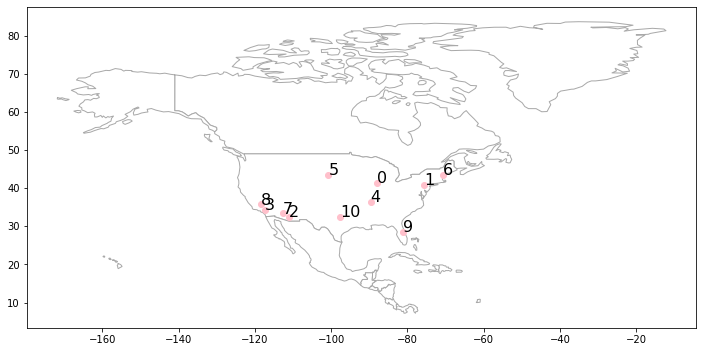

In [69]:
# plot the map again
gdf = gpd.GeoDataFrame(random_air, 
                       geometry=gpd.points_from_xy(random_air.longitude_deg, random_air.latitude_deg))

ax = world[world.continent == 'North America'].plot(color='white', edgecolor='darkgrey')
for x, y, label in zip(random_air.longitude_deg, random_air.latitude_deg, random_air.nid):
    ax.annotate(label, xy=(x, y), xytext=(0, 0), fontsize=16, textcoords="offset points")
gdf.plot(ax=ax, color='pink')

# Conclusion

The optimal path for these trips is to have one airplane handle the northeast trip (1->6), another handle the long, central trip (5->9) and the third to cover all of the southwest.

Additional extensions would include capacity limits (to prevent overlapping/shared trips) and/or time window constraints.